# Face Detection and Extraction
## Viola-Jones partial implementation
2021-12-03

In [ ]:
# import libraries
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import numpy.random as npr
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tarfile
import matplotlib.image as image
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation

!pip install nms
from nms import nms

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## Loading Image Data
### Images of Groups dataset
http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html using Fam2a collection.

In [ ]:
def unzip_tar_file(source_path,destination_path):
    '''
    Read contents of .tar file into memory in Google Colab.
    '''
    zip_ref = tarfile.TarFile(source_path, 'r') 
    zip_ref.extractall(destination_path) 
    zip_ref.close()

In [ ]:
group_path = '/content/gdrive/MyDrive/Colab Notebooks/Project/data/detection_data.tar'
dest_path = '/content'
#group_path = "path-to-detection_data.tar"
#dest_path = "path-to-file-destination"
unzip_tar_file(group_path, dest_path)

group_path = '/content/gdrive/MyDrive/Colab Notebooks/Project/data/detection_data_test.tar'
unzip_tar_file(group_path, dest_path)

In [ ]:
# define function to load data from Drive using ImageFolder
def label_flip(label):
    return int(not label)

def get_data(data_dir):
    transform = transforms.Compose([ 
        transforms.Resize(100),    
        transforms.CenterCrop(100),
        transforms.ToTensor()
        ])

    dataset = datasets.ImageFolder(data_dir, transform=transform, target_transform=label_flip)
    return dataset

# define function to display data
def display_data(dataset,num_imgs,start_ind=0):
    # get neat number of images to plot
    divisor1 = 1
    for i in range(1,int(num_imgs/2)+1):
        if num_imgs % i == 0:
            divisor1 = i
    divisor2 = int(num_imgs/divisor1)

    # plot images in grid
    for k in range(0,num_imgs):
        plt.subplot(divisor2, divisor1, k+1)
        plt.axis('off')
        cur_img = dataset[k+start_ind][0].numpy()
        cur_img = np.clip(cur_img,a_min = 0, a_max = 1)
        cur_img = np.transpose(cur_img, (1, 2, 0))
        plt.imshow(cur_img)
        plt.title("Label="+str(dataset[k+start_ind][1]))

Length of facial recognition dataset is:  7421
Sample face data:


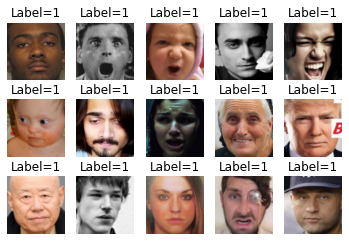

In [ ]:
full_set = get_data('detection_data')
print("Length of facial recognition dataset is: ",len(full_set))

# visualize a sample from each set to check
print("Sample face data:")
display_data(full_set,15)

Sample non-face data:


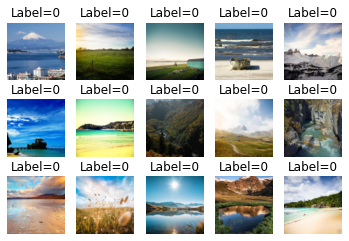

In [ ]:
print("Sample non-face data:")
display_data(full_set,15,int(len(full_set)/2+1))

Length of facial recognition dataset is:  998
Sample data:


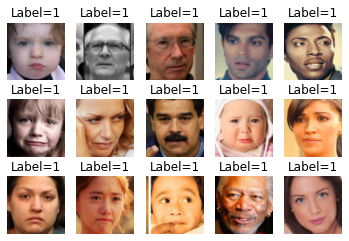

In [ ]:
test_set = get_data('detection_data_test')
print("Length of facial recognition dataset is: ",len(test_set))

# visualize a sample from each set to check
print("Sample data:")
display_data(test_set,15)

# Preprocess Images
Shuffle, normalize, and convert to greyscale

In [ ]:
# convert colour images into greyscale
def process(xs, max_pixel=255.0, downsize_input=False,axis=1):
    """
    Pre-process images by shuffling, and have colour values  bound between 0 & 1

    Args:
      xs: the colour RGB pixel values
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    if len(xs) > 1:
        npr.shuffle(xs)

    grey = np.mean(xs, axis=axis, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)

# Feature Generation
## Integral Image

In [ ]:
def integral_img(img):
  '''
  Transform an image into an integral image representation using recursive 
  relationships.
  '''
  img_shape = np.shape(img)
  int_img = np.zeros(img_shape)
  
  for i in range(img_shape[0]):
      row_sum = np.zeros((img_shape[1]))

      # for first row of image, set integral img equal to row sums
      if i == 0:
          prev_row = np.zeros((img_shape[1]))
      # for all other rows, add row sums to integral img value in previous row
      else:
          prev_row = int_img[i - 1]
      
      # compute integral image values for current row
      for j in range(img_shape[1]):
          row_sum[j] = row_sum[j-1] + img[i,j]
      int_img[i] = prev_row + row_sum

  return int_img

### Integral Image Test

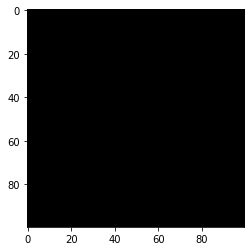

In [ ]:
i = np.zeros(np.shape(full_set[0][0][0]))
fig = plt.figure(figsize=(25, 4))
plt.imshow(i,cmap="gray")

Minimum integral image value is  0.0
Maximum integral image value is  0.0
Image value at top left is  0.0
Integral image value at top left is  0.0
Integral image value at top right is  0.0
Image value at second row start is  0.0
Integral image value at second row start is  0.0


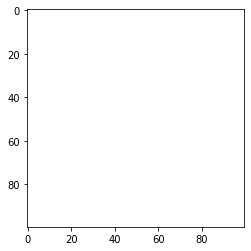

In [ ]:
ii = integral_img(i)
print("Minimum integral image value is ",np.min(ii))
print("Maximum integral image value is ",np.max(ii))

print("Image value at top left is ",i[0][0])
print("Integral image value at top left is ",ii[0][0])
print("Integral image value at top right is ",ii[0][-1])

print("Image value at second row start is ",i[1][0])
print("Integral image value at second row start is ",ii[1][0])

fig = plt.figure(figsize=(25, 4))
plt.imshow(ii/np.max(ii),cmap="gray")

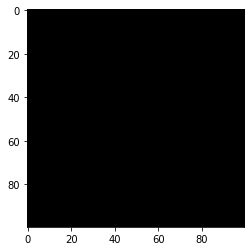

In [ ]:
i = np.ones(np.shape(full_set[0][0][0]))
fig = plt.figure(figsize=(25, 4))
plt.imshow(i,cmap="gray")

Minimum integral image value is  1.0
Maximum integral image value is  10000.0
Image value at top left is  1.0
Integral image value at top left is  1.0
Integral image value at top right is  100.0
Image value at second row start is  1.0
Integral image value at second row start is  2.0


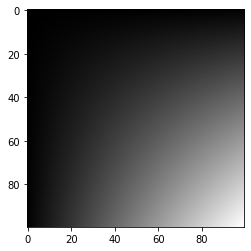

In [ ]:
ii = integral_img(i)
print("Minimum integral image value is ",np.min(ii))
print("Maximum integral image value is ",np.max(ii))

print("Image value at top left is ",i[0][0])
print("Integral image value at top left is ",ii[0][0])
print("Integral image value at top right is ",ii[0][-1])

print("Image value at second row start is ",i[1][0])
print("Integral image value at second row start is ",ii[1][0])

fig = plt.figure(figsize=(25, 4))
plt.imshow(ii/np.max(ii),cmap="gray")

### Integral Image Example

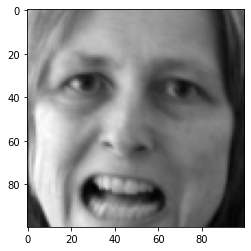

In [ ]:
(i_colour, i) = process(full_set[100][0].numpy(),axis=0)

fig = plt.figure(figsize=(25, 4))
plt.imshow(i[0],cmap='gray')

Minimum integral image value is  0.0021273873280733824
Maximum integral image value is  14.854482195456512
Image value at top left is  0.0021273873
Integral image value at top left is  0.0021273873280733824
Integral image value at top right is  0.15470973154879175
Image value at second row start is  0.0022196593
Integral image value at second row start is  0.0043470466043800116


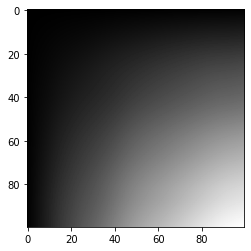

In [ ]:
ii = integral_img(i[0])
print("Minimum integral image value is ",np.min(ii))
print("Maximum integral image value is ",np.max(ii))

print("Image value at top left is ",i[0][0][0])
print("Integral image value at top left is ",ii[0][0])
print("Integral image value at top right is ",ii[0][-1])

print("Image value at second row start is ",i[0][1][0])
print("Integral image value at second row start is ",ii[1][0])

fig = plt.figure(figsize=(25, 4))
plt.imshow(ii/np.max(ii),cmap='gray')

### Integral Image Summing

Corners of rectangle used with integral image to compute pixel sum within rectangle: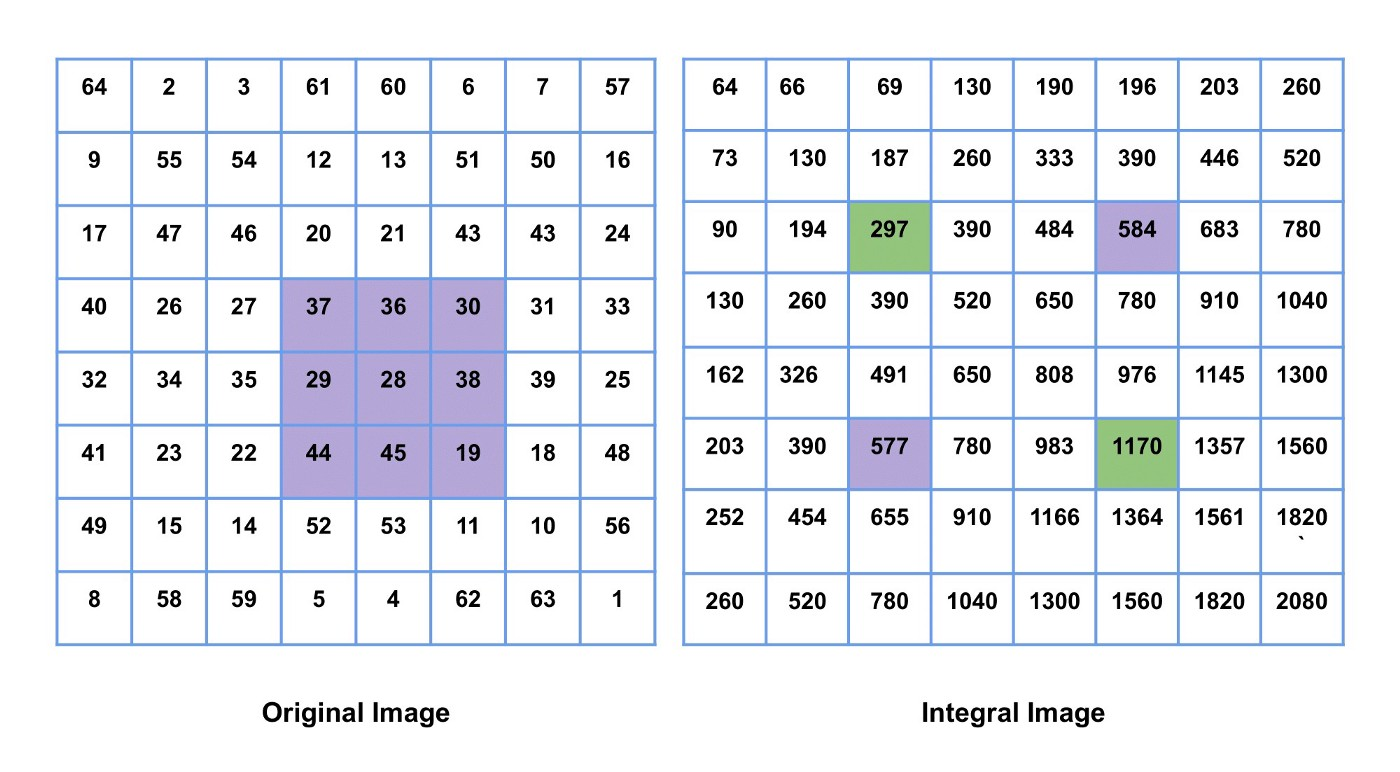 from https://towardsdatascience.com/viola-jones-algorithm-and-haar-cascade-classifier-ee3bfb19f7d8

In [ ]:
def region_sum(integral_image,a,b,c,d):
  '''
  Computes sum of pixels in a rectangle region using integral image and the 
  corners of the rectangle.
  '''
  rectangle_sum = integral_image[a[0]-1][a[1]-1]
  rectangle_sum -= integral_image[b[0]-1][b[1]]
  rectangle_sum -= integral_image[c[0]][c[1]-1]
  rectangle_sum += integral_image[d[0]][d[1]]
  return rectangle_sum

In [ ]:
print("Sample region of image:")
print(i[0,2:5,2:5])
print("Pixel sum of sample region: ",np.sum(i[0,2:5,2:5]))

print("Corner a is ",ii[2-1][2-1])
print("Corner b is ",ii[2-1][4])
print("Corner c is ",ii[4][2-1])
print("Corner d is ",ii[4][4])
print("Results of region sum from integral image: ",region_sum(ii,(2,2),(2,4),(4,2),(4,4)))

Sample region of image:
[[0.00192746 0.00188133 0.00174292]
 [0.00192746 0.00186595 0.00166603]
 [0.0019736  0.00185057 0.00158913]]
Pixel sum of sample region:  0.016424453
Corner a is  0.008601820794865489
Corner b is  0.019766757730394602
Corner c is  0.020858646254055202
Corner d is  0.04844803595915437
Results of region sum from integral image:  0.016424452769570053


## Haar Wavelets
Haar wavelets used in varying configurations

In [ ]:
def haar_wavelets(num_trans,trans_dir):
    '''
    Generate haar wavelets with specific numbers of regions in the specified 
    directions (e.g. use num_trans=2, trans_dir=1 to specify two vertical wavelet 
    sections)
    '''
    pass

# Viola-Jones

The following code is mostly from https://github.com/salvacarrion/viola-jones with some adaptations.

In [ ]:
class_mapping = {("no_face",0),("face",1)}

def load_dataset(filepath=None,batch_size=1000):
    '''
    Uses ImageFolder dataset to make lists of images and their labels
    '''
    data = get_data(filepath)
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)
    return data_loader

def make_npy_dataset(set_size,save_path,source_path=None):
    '''
    Loads subset of dataset into .npy feature file
    '''
    print("Loading data into dataset...")
    loader = load_dataset(source_path,set_size)
    print("Data loader built!")

    # Modify sizes
    data, lbls = next(iter(loader))
    data = data.numpy()
    lbls = lbls.numpy()

    # Save current dataset
    print("Loading data into npy...")
    if not os.path.exists(save_path):
        os.mkdir(features_path)

    # save images in greyscale!
    (colour_data,data) = process(data)
    np.save(save_path + "img.npy", data)
    np.save(save_path + "lbl.npy", lbls)
    
    print("Data loaded!")

In [ ]:
# test run to make feature dataset saves
test_size = 1000
dataset_path = "detection_data"
if not os.path.exists("weights/"):
    os.mkdir("weights/")
features_path = "weights/{}/".format(test_size)
#dataset_path = 
#features_path = "/path_to_data/{}/".format(test_size)

make_npy_dataset(test_size,features_path,dataset_path)

Loading data into dataset...
Data loader built!
Loading data into npy...
Data loaded!


In [ ]:
class WeakClassifier:
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    def __init__(self, haar_feature=None, threshold=None, polarity=None):
        self.haar_feature = haar_feature
        self.threshold = threshold
        self.polarity = polarity

    def classify(self, ii, scale=1.0):
        """
        Classifies an image given its (integral) image "x"
        """
        feature_value = self.haar_feature.compute_value(ii, scale)
        return 1 if self.polarity * feature_value < self.polarity * self.threshold * (scale**2) else 0

    def classify_f(self, feature_value):
        """
        Classifies an image given its feature vale or array
        """
        a = self.polarity * feature_value
        b = self.polarity * self.threshold
        return np.less(a, b).astype(int)

    def train(self, X, y, weights, total_pos_weights=None, total_neg_weights=None):
        # Compute total pos/neg weights if not given
        if not total_pos_weights:
            total_pos_weights = np.sum(weights[np.where(y == 1)])
        if not total_neg_weights:
            total_neg_weights = np.sum(weights[np.where(y == 0)])

        # Sort features according to their numeric value
        sorted_features = sorted(zip(weights, X, y), key=lambda a: a[1])

        pos_seen, neg_seen = 0, 0
        sum_pos_weights, sum_neg_weights = 0, 0

        min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None
        for w, f, label in sorted_features:
            # MIN( (w*No-faces + w*Remaining_faces), (w*Faces + w*Remaining_No-faces) )
            error = min(sum_neg_weights + (total_pos_weights - sum_pos_weights),
                        sum_pos_weights + (total_neg_weights - sum_neg_weights))

            # Save best values
            if error < min_error:
                min_error = error
                self.threshold = f  # Best feature value
                self.polarity = 1 if pos_seen > neg_seen else -1

            # Keep counts
            if label == 1:
                pos_seen += 1
                sum_pos_weights += w
            else:
                neg_seen += 1
                sum_neg_weights += w

In [ ]:
class RectangleRegion:
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

        # self.x1 = int(x - 1)
        # self.y1 = int(y - 1)
        # self.x2 = int(x + width - 1)
        # self.y2 = int(y + height - 1)

    def compute_region(self, ii, scale=1.0):
        # D(all) - C(left) - B(top) + A(corner)

        # x1 = self.x
        # y1 = self.y
        # x2 = x1 + self.width - 1
        # y2 = y1 + self.height - 1

        x1 = int(self.x * scale)
        y1 = int(self.y * scale)
        x2 = x1 + int(self.width * scale) - 1
        y2 = y1 + int(self.height * scale) - 1

        S = int(ii[x2, y2])
        if x1 > 0: S -= int(ii[x1-1, y2])
        if y1 > 0: S -= int(ii[x2, y1-1])
        if x1 > 0 and y1 > 0: S += int(ii[x1 - 1, y1 - 1])
        return S  # Due to the use of substraction with unsigned values


class HaarFeature:
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    def __init__(self, positive_regions, negative_regions):
        self.positive_regions = positive_regions  # White
        self.negative_regions = negative_regions  # Black

    def compute_value(self, ii, scale=1.0):
        """
        Compute the value of a feature(x,y,w,h) at the integral image
        """

        sum_pos = sum([rect.compute_region(ii, scale) for rect in self.positive_regions])
        sum_neg = sum([rect.compute_region(ii, scale) for rect in self.negative_regions])
        return sum_neg - sum_pos


In [ ]:
import time
import glob
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import multiprocessing

def load_image(image_path, as_numpy=False):
    pil_img = Image.open(image_path)
    if as_numpy:
        return np.array(pil_img)
    else:
        return pil_img

def rgb2gray(img):
    # Formula: https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    return np.dot(img[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

def integral_image_pow2(img):
    """
    Squared version of II, https://github.com/salvacarrion/viola-jones
    """
    #return integral_image(img**2)
    return integral_img(img**2)

def build_features(img_w, img_h, shift=4, scale_factor=1.25, min_w=4, min_h=4):
    """
    Generate values from Haar features, https://github.com/salvacarrion/viola-jones
    White rectangles substract from black ones
    """
    features = []  # [Tuple(positive regions, negative regions),...]

    # Scale feature window
    print(img_w)
    print(img_h)
    print(30*"=")
    for w_width in range(min_w, img_w + 1):
        #print(w_width)
        for w_height in range(min_h, img_h + 1):
            # Walk through all the image
            x = 0
            while x + w_width < img_w:
                y = 0
                while y + w_height < img_h:

                    # Possible Haar regions
                    immediate = RectangleRegion(x, y, w_width, w_height)  # |X|
                    right = RectangleRegion(x + w_width, y, w_width, w_height)  # | |X|
                    right_2 = RectangleRegion(x + w_width * 2, y, w_width, w_height)  # | | |X|
                    bottom = RectangleRegion(x, y + w_height, w_width, w_height)  # | |/|X|
                    #bottom_2 = RectangleRegion(x, y + w_height * 2, w_width, w_height)  # | |/| |/|X|
                    bottom_right = RectangleRegion(x + w_width, y + w_height, w_width, w_height)  # | |/| |X|

                    # [Haar] 2 rectagles *********
                    # Horizontal (w-b)
                    if x + w_width * 2 < img_w:
                        features.append(HaarFeature([immediate], [right]))
                    # Vertical (w-b)
                    if y + w_height * 2 < img_h:
                        features.append(HaarFeature([bottom], [immediate]))

                    # [Haar] 3 rectagles *********
                    # Horizontal (w-b-w)
                    if x + w_width * 3 < img_w:
                        features.append(HaarFeature([immediate, right_2], [right]))
                    # # Vertical (w-b-w)
                    # if y + w_height * 3 < img_h:
                    #     features.append(HaarFeature([immediate, bottom_2], [bottom]))

                    # [Haar] 4 rectagles *********
                    if x + w_width * 2 < img_w and y + w_height * 2 < img_h:
                        features.append(HaarFeature([immediate, bottom_right], [bottom, right]))

                    y += shift
                x += shift
    return features  # np.array(features)

def apply_features(X_ii, features):
    """
    https://github.com/salvacarrion/viola-jones
    Apply build features (regions) to all the training data (integral images)
    """
    X = np.zeros((len(features), len(X_ii)), dtype=np.int32)
    # 'y' will be kept as it is => f0=([...], y); f1=([...], y),...

    for j, feature in tqdm(iter(enumerate(features))):
    # for j, feature in enumerate(features):
    #     if (j + 1) % 1000 == 0 and j != 0:
    #         print("Applying features... ({}/{})".format(j + 1, len(features)))

        # Compute the value of feature 'j' for each image in the training set (Input of the classifier_j)
        X[j] = list(map(lambda ii: feature.compute_value(ii), X_ii))

    return X

def show_sample(x, y, y_pred):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    target = "Face" if y == 1 else "No face"
    pred = "Face" if y_pred == 1 else "No face"
    img_text = "Class: {}  - Prediction: {}".format(target, pred)
    print(img_text)

    plt.title(img_text)
    plt.imshow(x, cmap='gray')
    plt.show()

def chunks(l, n):
    """
    https://github.com/salvacarrion/viola-jones
    Yield successive n-sized chunks from l.
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]

def get_pretty_time(start_time, end_time=None, s="", divisor=1.0):
    if not end_time:
        end_time = time.time()
    hours, rem = divmod((end_time - start_time)/divisor, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{}{:0>2}:{:0>2}:{:05.8f}".format(s, int(hours), int(minutes), seconds)

def draw_bounding_boxes(pil_image, regions, color="green", thickness=3):
    # Prepare image
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    source_img = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(source_img)
    for rect in regions:
        draw.rectangle(tuple(rect), outline=color, width=thickness)
    return source_img

def non_maximum_supression(regions, threshold=0.5):
    # Code from: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list
    boxes = np.array(regions)
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > threshold)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

def non_max_suppression(boxes, scores, threshold):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    assert boxes.shape[0] == scores.shape[0]
    # bottom-left origin
    ys1 = boxes[:, 0]
    xs1 = boxes[:, 1]
    # top-right target
    ys2 = boxes[:, 2]
    xs2 = boxes[:, 3]
    # box coordinate ranges are inclusive-inclusive
    areas = (ys2 - ys1) * (xs2 - xs1)
    scores_indexes = scores.argsort().tolist()
    boxes_keep_index = []
    while len(scores_indexes):
        index = scores_indexes.pop()
        boxes_keep_index.append(index)
        if not len(scores_indexes):
            break
        ious = compute_iou(boxes[index], boxes[scores_indexes], areas[index],
                           areas[scores_indexes])
        filtered_indexes = set((ious > threshold).nonzero()[0])
        # if there are no more scores_index
        # then we should pop it
        scores_indexes = [
            v for (i, v) in enumerate(scores_indexes)
            if i not in filtered_indexes
        ]
    return np.array(boxes_keep_index)

def compute_iou(box, boxes, box_area, boxes_area):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    # this is the iou of the box against all other boxes
    assert boxes.shape[0] == boxes_area.shape[0]
    # get all the origin-ys push up all the lower origin-xs, while keeping the higher origin-xs
    ys1 = np.maximum(box[0], boxes[:, 0])
    # get all the origin-xs push right all the lower origin-xs, while keeping higher origin-xs
    xs1 = np.maximum(box[1], boxes[:, 1])
    # get all the target-ys pull down all the higher target-ys, while keeping lower origin-ys
    ys2 = np.minimum(box[2], boxes[:, 2])
    # get all the target-xs pull left all the higher target-xs, while keeping lower target-xs
    xs2 = np.minimum(box[3], boxes[:, 3])
    # each intersection area is calculated by the pulled target-x minus the pushed origin-x\  multiplying  pulled target-y minus the pushed origin-y
    # we ignore areas where the intersection side would be negative  this is done by using maxing the side length by 0
    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)
    # each union is then the box area added to each other box area minusing their intersection calculated above
    unions = box_area + boxes_area - intersections
    # element wise division if the intersection is 0, then their ratio is 0
    ious = intersections / unions
    return ious

def normalize_image(image):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    #ii = integral_image(image)
    ii = integral_img(image)
    mean = np.mean(image)
    stdev = np.std(image)
    norm_img = (image-mean)/stdev
    return norm_img

def draw_haar_feature(np_img, haar_feature):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    pil_img = Image.fromarray(np_img).convert("RGBA")

    draw = ImageDraw.Draw(pil_img)
    for rect in haar_feature.positive_regions:
        x1, y1, x2, y2 = rect.x, rect.y, rect.x + rect.width - 1, rect.y + rect.height - 1
        draw.rectangle([x1, y1, x2, y2], fill=(255, 255, 255, 255))

    for rect in haar_feature.negative_regions:
        x1, y1, x2, y2 = rect.x, rect.y, rect.x + rect.width - 1, rect.y + rect.height - 1
        draw.rectangle([x1, y1, x2, y2], fill=(0, 0, 0, 255))

    return pil_img

In [ ]:
import math


class AdaBoost:
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.alphas = []
        self.clfs = []

    def train(self, X, y, features, X_ii):
        pos_num = np.sum(y)
        neg_num = len(y)-pos_num
        weights = np.zeros(len(y), dtype=np.float32)

        # Initialize weights
        for i in range(len(y)):
            if y[i] == 1:  # Face
                weights[i] = 1.0 / (pos_num * 2.0)
            else:  # No face
                weights[i] = 1.0 / (neg_num * 2.0)

        # Training
        print("Training...")
        start_time = time.time()
        # bar = Bar('Training viola-jones...', max=self.T, suffix='%(percent)d%% - %(elapsed_td)s - %(eta_td)s')
        # for t in bar.iter(range(self.T)):
        for t in range(self.n_estimators):
            print("Training %d classifiers out of %d" % (t+1, self.n_estimators))

            # Normalize weights
            w_sum = np.sum(weights)
            if w_sum == 0.0:
                print("[WARNING] EARLY STOP. WEIGHTS ARE ZERO.")
                break
            weights = weights / w_sum  #np.linalg.norm(weights)

            # Train weak classifiers (one per feature)
            print("Training weak classifiers...")
            start_time2 = time.time()
            weak_classifiers = self.train_estimators(X, y, weights, features)
            print("\t- Num. weak classifiers: {:,}".format(len(weak_classifiers)))
            print("\t- WC/s: " + get_pretty_time(start_time2, divisor=len(weak_classifiers)))
            print("\t- Total time: " + get_pretty_time(start_time2))

            # Select classifier with the lowest error
            start_time2 = time.time()
            print("Selecting best weak classifiers...")
            clf, error, incorrectness = self.select_best(weak_classifiers, X, y, weights)
            #clf, error, incorrectness = self.select_best2(weak_classifiers, weights, X_ii, y,)
            print("\t- Num. weak classifiers: {:,}".format(len(weak_classifiers)))
            print("\t- WC/s: " + get_pretty_time(start_time2, divisor=len(weak_classifiers)))
            print("\t- Total time: " + get_pretty_time(start_time2))

            if error <= 0.5:
                # Compute alpha, beta
                beta = error / (1.0 - error)
                alpha = math.log(1.0 / (beta + 1e-18))  # Avoid division by zero

                # Update weights
                weights = np.multiply(weights, beta ** (1 - incorrectness))

                # Save parameters
                self.alphas.append(alpha)
                self.clfs.append(clf)
            else:
                print(error)

        print("<== Training")
        print("\t- Num. classifiers: {:,}".format(self.n_estimators))
        print("\t- FA/s: " + get_pretty_time(start_time, divisor=self.n_estimators))
        print("\t- Total time: " + get_pretty_time(start_time))

    def train_estimators(self, X, y, weights, features):
        """
        Find optimal threshold given current weights
        """
        # Precomputation and initializations
        # This is faster than its numpy version
        weak_clfs = []
        total_pos_weights, total_neg_weights = 0, 0
        for w, label in zip(weights, y):
            if label == 1:
                total_pos_weights += w
            else:
                total_neg_weights += w

        for i in tqdm(iter(range(len(X)))):
        # for i in range(len(X)):
        #     if (i+1) % 1000 == 0 and i != 0:
        #         print("Training weak classifiers... ({}/{})".format(i + 1, len(X)))

            # Train weak classifier
            clf = WeakClassifier(haar_feature=features[i])  # Index of features
            clf.train(X[i], y, weights, total_pos_weights, total_neg_weights)
            weak_clfs.append(clf)

        return weak_clfs

    def select_best(self, weak_clfs, X, y, weights):
        best_clf, min_error, best_accuracy = None, float('inf'), None

        i=-1
        for clf in tqdm(iter(weak_clfs)):
            i+=1
        # for i, clf in enumerate(weak_clfs):
        #     if (i+1) % 1000 == 0 and i != 0:
        #         print("Selecting weak classifiers... ({}/{})".format(i+1, len(weak_clfs)))

            # If real==predicted => real - predicted == 0
            # X[0] => List of feature values of the feature F_i of the all imagenes: [2, -6, 4, -7]
            incorrectness = np.abs(clf.classify_f(X[i]) - y)
            error = float(np.sum(np.multiply(incorrectness, weights))) / len(incorrectness)  # Mean error

            if error < min_error:
                best_clf, min_error, best_accuracy = clf, error, incorrectness

        return best_clf, min_error, best_accuracy

    def select_best2(self, classifiers, weights, X_ii, y):
        """
        Selects the best weak classifier for the given weights
          Args:
            classifiers: An array of weak classifiers
            weights: An array of weights corresponding to each training example
            training_data: An array of tuples. The first element is the numpy array of shape (m, n) representing the integral image. The second element is its classification (1 or 0)
          Returns:
            A tuple containing the best classifier, its error, and an array of its accuracy
        """
        best_clf, best_error, best_accuracy = None, float('inf'), None
        for clf in classifiers:
            error, accuracy = 0, []
            for xii_i, yi, w in zip(X_ii, y, weights):
                correctness = abs(clf.classify(xii_i) - yi)
                accuracy.append(correctness)
                error += w * correctness
            error = error / len(X_ii)
            if error < best_error:
                best_clf, best_error, best_accuracy = clf, error, accuracy
        return best_clf, best_error, np.array(best_accuracy)

    def classify(self, X, scale=1.0):
        total = sum(list(map(lambda x: x[0] * x[1].classify(X, scale), zip(self.alphas, self.clfs))))  # Weak classifiers
        return 1 if total >= 0.5 * sum(self.alphas) else 0

In [ ]:
import pickle
import time
import numpy as np

from sklearn.feature_selection import SelectPercentile, f_classif


class ViolaJones:
    '''
    https://github.com/salvacarrion/viola-jones
    '''

    def __init__(self, layers, features_path=None):
        assert isinstance(layers, list)
        self.layers = layers  # list with the number T of weak classifiers
        self.clfs = []
        self.base_width, self.base_height = 19, 19  # Size of the images from training dataset
        self.base_scale, self.shift = 1.25, 2
        self.features_path = features_path  # Path to save the features

    def train(self, X, y):
        """
        We train N Viola-Jones classifiers (AdaBoost), each more complex than the previous ones.
        After the first one, each classifier is trained with the positive examples plus
        the false positives of the previous one.
        """

        print("Preparing data...")

        # Prepare training data
        pos_num = np.sum(y)
        neg_num = len(y) - pos_num
        print(pos_num)
        print(neg_num)
        X = X.squeeze()
        print(X[0].shape)
        img_h, img_w = X[0].shape  # All training images must have the same size

        # Split positives and negatives samples
        pos_indices = np.where(y == 1)[0]
        neg_indices = np.where(y == 0)[0]

        # Show data info
        print("Summary input data:")
        print("\t- Total faces: {:,} ({:.2f}%)".format(int(pos_num), 100.0 * pos_num / (pos_num + neg_num)))
        print("\t- Total non-faces: {:,} ({:.2f}%)".format(int(neg_num), 100.0 * neg_num / (pos_num + neg_num)))
        print("\t- Total samples: {:,}".format(int(pos_num + neg_num)))
        print("\t- Size (WxH): {}x{}".format(img_w, img_h))

        # Initialize weights and compute integral images
        print("Generating integral images...")
        start_time = time.time()
        #X_ii = np.array(list(map(lambda x: integral_img(x), X)), dtype=np.uint32)
        X_ii = np.array(list(map(lambda x: integral_image(x), X)), dtype=np.uint32)
        print("\t- Num. integral images: {:,}".format(len(X_ii)))
        print("\t- II/s: " + get_pretty_time(start_time, divisor=len(y)))
        print("\t- Total time: " + get_pretty_time(start_time))

        # Create and apply features
        print("Building features...")
        start_time = time.time()
        features = build_features(img_w, img_h)  # Same features for all images
        print("\t- Num. features: {:,}".format(len(features)))
        print("\t- F/s: " + get_pretty_time(start_time, divisor=len(features)))
        print("\t- Total time: " + get_pretty_time(start_time))

        print("Applying features...")
        start_time = time.time()
        X_f = self.__load_feature_dataset()  # Load feature dataset (if exists)
        if X_f is None:
            X_f = apply_features(X_ii, features)

            if self.features_path:  # Save features
                np.save(self.features_path + "xf" + ".npy", X_f)
                print("Applied features file saved!")
        print("\t- Num. features applied: {:,}".format(len(X_f) * len(features)))
        print("\t- FA/s: " + get_pretty_time(start_time, divisor=len(X_f) * len(features)))
        print("\t- Total time: " + get_pretty_time(start_time))

        # # Percentile optimization
        # indices = SelectPercentile(f_classif, percentile=10).fit(X_f.T, y).get_support(indices=True)
        # X_f = X_f[indices]
        # features = np.array(features)[indices]

        # Train cascade of Viola-Jones classifiers (AdaBoost)
        for i, t in enumerate(self.layers):
            print("[CascadeClassifier] Training {} of out {} layers".format(i+1, len(self.layers)))
            if len(neg_indices) == 0:
                print('Early stop. All samples were correctly classify.')
                break

            # Merge indices and shuffle
            tr_idxs = np.concatenate([pos_indices, neg_indices])
            np.random.shuffle(tr_idxs)

            # Train Viola-Jones (AdaBoost)
            clf = AdaBoost(n_estimators=t)
            clf.train(X_f[:, tr_idxs], y[tr_idxs], features, X_ii[tr_idxs])
            self.clfs.append(clf)

            # Find which non-faces where label as a face
            false_positives = []
            for neg_idx in neg_indices:
                print(self.classify(X[neg_idx]))
                if self.classify(X[neg_idx]) == 1:
                    false_positives.append(neg_idx)
            neg_indices = np.array(false_positives)

    def classify(self, image, scale=1.0):
        """
        If a no-face is found, reject now. Else, keep looking.
        """
        #return self.classify_ii(integral_image(image), scale)
        return self.classify_ii(integral_img(image), scale)

    def classify_ii(self, ii, scale=1.0):
        """
        If a no-face is found, reject now. Else, keep looking.
        """
        for clf in self.clfs:  # ViolaJones
            if clf.classify(ii, scale) == 0:
                return 0
        return 1

    def find_faces(self, pil_image):
        """
        Receives a PIL image
        """
        w, h, s = (self.base_width, self.base_height, self.base_scale)
        regions = []

        # Preprocess image
        pil_image = pil_image.convert('L')
        image = np.array(pil_image)
        img_h, img_w = image.shape

        # Compute integral image
        ii = integral_image(image)

        # Sliding window
        # Box must be smaller than the image
        counter = 0
        while int(w*s) < img_w and int(h*s) < img_h:

            # The box must slide just in the image
            for y1 in np.arange(0, int(img_h)-int(h*s), self.shift):
                for x1 in np.arange(0, int(img_w)-int(w*s), self.shift):
                    y1, x1 = int(y1), int(x1)
                    y2, x2 = y1 + int(h*s), x1 + int(w*s)
                    cropped_img = ii[y1:y2, x1:x2]

                    if self.classify_ii(cropped_img, scale=s):  # CascadeClassifier
                        regions.append((x1, y1, x2, y2))

                    counter += 1
                    print("Crops analized: {}".format(counter))

            # Increase scale of the window
            w *= s
            h *= s

        return regions

    def save(self, filename):
        with open(filename + ".pkl", 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

    def __load_feature_dataset(self):
        X_f = None
        # Load precomputed features
        try:
            if self.features_path:
                X_f = np.load(self.features_path + "xf" + ".npy")
                print("Precomputed dataset loaded!")
        except FileNotFoundError:
            pass
        return X_f

In [ ]:
"""
Viola-Jones Algorithm
"""
def train(features_path):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    # Load precomputed dataset
    imgs = np.load(features_path + "img.npy")
    print(np.shape(imgs))
    lbls = np.load(features_path + "lbl.npy")
    print("Dataset loaded!")

    # Train
    print("\nTraining Viola-Jones...")
    clf = ViolaJones(layers=[1, 10, 50, 100], features_path=features_path)
    clf.train(imgs, lbls)  # X_f (optional, to speed-up training)
    print("Training finished!")

    # Save weights
    print("\nSaving weights...")
    clf.save(features_path + 'cvj_weights_' + str(int(time.time())))
    print("Weights saved!")

    return clf

In [ ]:
start_time = time.time()
print("Starting scripting...")

# Training
clf = train(features_path)

# Elapsed time
print("\n" + get_pretty_time(start_time, s="Total time (Training+test): "))

Starting scripting...
(1000, 1, 100, 100)
Dataset loaded!

Training Viola-Jones...
Preparing data...
480
520
(100, 100)
Summary input data:
	- Total faces: 480 (48.00%)
	- Total non-faces: 520 (52.00%)
	- Total samples: 1,000
	- Size (WxH): 100x100
Generating integral images...
	- Num. integral images: 1,000
	- II/s: 00:00:0.05032699
	- Total time: 00:00:50.32704973
Building features...
100
100
	- Num. features: 2,043,504
	- F/s: 00:00:0.00000702
	- Total time: 00:00:14.33949852
Applying features...


1905453it [4:31:45, 138.14it/s]

In [ ]:
def evaluate(clf, X, y, show_samples=False):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    metrics = {}
    true_positive, true_negative = 0, 0  # Correct
    false_positive, false_negative = 0, 0  # Incorrect

    X = X.squeeze()
    print(np.shape(X))
    print(y)
    for i in range(len(y)):
        fig = plt.figure(figsize=(25, 4))
        plt.imshow(X[i],cmap='gray')
        prediction = clf.classify(X[i])
        print(prediction)
        if prediction == y[i]:  # Correct
            if prediction == 1:  # Face
                true_positive += 1
            else:  # No-face
                true_negative += 1
        else:  # Incorrect
            #if show_samples: show_sample(X[i], y[i], prediction)

            if prediction == 1:  # Face
                false_positive += 1
            else:  # No-face
                false_negative += 1

    # Compute metrics
    metrics['true_positive'] = true_positive
    metrics['true_negative'] = true_negative
    metrics['false_positive'] = false_positive
    metrics['false_negative'] = false_negative
    print(metrics)

    metrics['accuracy'] = (true_positive + true_negative)/(true_positive+false_negative+true_negative+false_positive)
    metrics['precision'] = true_positive / (true_positive+false_positive)
    metrics['recall'] = true_positive / (true_positive+false_negative)  # or Sensitivity
    metrics['specifity'] = true_negative/(true_negative+false_positive)
    metrics['f1'] = (2.0 * metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])

    return metrics
    
def test(clf, features_path, set_size, name=""):
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    # Load test set
    print("\nLoading {}...".format(name))
    loader = load_dataset(features_path,set_size)
    print("Data loader built!")

    # Modify sizes
    data, lbls = next(iter(loader))
    data = data.numpy()
    lbls = lbls.numpy()
    (colour_data,data) = process(data)

    # Evaluate
    print("\nEvaluating...")
    metrics = evaluate(clf, data, lbls, show_samples=False)

    print("Metrics: [{}]".format(name))
    counter = 0
    for k, v in metrics.items():
        counter += 1
        if counter <= 4:
            print("\t- {}: {:,}".format(k, v))
        else:
            print("\t- {}: {:.3f}".format(k, v))

In [ ]:
# Test training
test(clf, "detection_data", 4, name="Training set")
test(clf, "test_face", 4, name="Test set")

In [ ]:
def find_faces():
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    weight_path = r"weights/500/cvj_weights_1638746950.pkl"
    #face_path = r"./datasets/judybats.jpg"
    #face_path = r"./datasets/i1.jpg"
    #face_path = r"./datasets/people.png"
    #face_path = r"./datasets/clase.png"
    face_path = r"./datasets/physics.jpg"


    # Load classifier weights
    clf = ViolaJones.load(weight_path)

    # Find regions of the faces
    pil_img = load_image(face_path)
    regions = clf.find_faces(pil_img)

    # Draw bouding boxes
    # TODO: Review Non-maximum supression (fix own implementation)
    # regions = np.array([(10, 10, 50, 50), (20, 20, 60, 60), (37, 59, 199, 244), (47, 69, 209, 254)])
    scores = [1.0]*len(regions)  #np.ones(len(regions))
    indicies = nms.boxes(regions, scores)
    regions = np.array(regions)
    drawn_img = draw_bounding_boxes(pil_img, list(regions[indicies]), thickness=1)
    # drawn_img = draw_bounding_boxes(pil_img, list(regions), thickness=1)

    # Show image
    plt.imshow(drawn_img)
    plt.show()

    # pil_image = load_image(face_path, as_numpy=False)
    # pil_image = pil_image.convert('L')
    # img = np.array(pil_image)
    # norm_img = normalize_image(img)
    # # Show image
    # plt.imshow(img, cmap="gray")
    # plt.show()
    # # Show image
    # plt.imshow(norm_img, cmap="gray")
    # plt.show()


def draw_features():
    '''
    https://github.com/salvacarrion/viola-jones
    '''
    test_name = 100
    MAX_FACES = 1
    video_folder = "videos"
    frames = []
    fig = plt.figure()

    # Load data
    X = np.load("weights/{}/x".format(test_name) + ".npy")
    y = np.load("weights/{}/y".format(test_name) + ".npy")

    X_faces = X[np.where(y == 1)]

    # Load model
    clf = ViolaJones.load("weights/500/cvj_weights_1638746950.pkl")

    for i, np_img in enumerate(X_faces):

        if i < MAX_FACES:
            # For each Adaboost in the Cascade
            for ab in clf.clfs:

                # For each Weak learner
                for wc in ab.clfs:
                    print("New frame: {}".format(len(frames)))

                    drawn_img = draw_haar_feature(np_img,  wc.haar_feature)
                    img = plt.imshow(drawn_img, cmap="gray")
                    frames.append([img])
                    #plt.savefig(video_folder + "/file_%d.png" % i)
                    #plt.show()

    ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                    repeat_delay=1000)
    ani.save(video_folder + "/{}/video_{}".format(test_name, test_name) + '.mp4', writer='ffmpeg')
    plt.show()

In [ ]:
find_faces()
draw_features()